In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
print(tf.__version__)

2.0.0


In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train.reshape([x_train.shape[0], -1])
x_test = x_test.reshape([x_test.shape[0], -1])

In [9]:
print(x_train.shape, ' ', y_train.shape)
print(x_test.shape, ' ', y_test.shape)

(60000, 784)   (60000,)
(10000, 784)   (10000,)


In [51]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.15)
print(x_train.shape, ' ', y_train.shape)
print(x_test.shape, ' ', y_test.shape)

(1404, 200)   (1404,)
(248, 200)   (248,)


In [30]:
import pandas as pd
import numpy as np

In [85]:
data = np.array(pd.read_csv('D:\!DTStack\Savefile_remote\lr_beta\zscore\data.csv',header=None))
np.random.shuffle(data)
x_data = data[:,0:-1]
y_data = data[:,-1]
print(x_data.shape,'\n')
print(y_data.shape)

(1652, 200) 

(1652,)


In [86]:
LFE_MLP_net = keras.Sequential([
        layers.Dense(450, activation='relu', input_shape=(200,)),
#         layers.Dense(450, activation='relu'),
        layers.Dense(2, activation='softmax')
    ])
LFE_MLP_net.compile(optimizer=keras.optimizers.Adam(),
                  loss=keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])
LFE_MLP_net.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 450)               90450     
_________________________________________________________________
dense_18 (Dense)             (None, 2)                 902       
Total params: 91,352
Trainable params: 91,352
Non-trainable params: 0
_________________________________________________________________


In [87]:
history = LFE_MLP_net.fit(x_data, y_data, batch_size=4, epochs=350, validation_split=0.05, verbose=0)

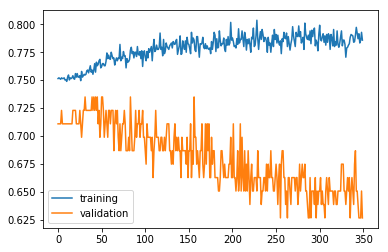

In [89]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'], loc='lower left')
plt.show()